# 1_Relay_Control_using_Simpy

In [21]:
import simpy.rt
import sys
sys.path.append("../TCLab")
from TCLab import TCLab

env = simpy.rt.RealtimeEnvironment(strict=False)
a = TCLab()
a.start()

SP = 40.0
def control(env):
    while True:
        a.Q1 = 100 if a.T1 <= SP else 0
        yield env.timeout(1)
         
def reporter(env):
    while True:
        print('{0:7.2f}   {1:7.2f}  {2:7.2f}'.format(env.now, a.Q1, a.T1), flush=True)
        yield env.timeout(5)
        
env.process(control(env))
env.process(reporter(env))
env.run(until=200)

# shutdown heater
a.stop()

Opening connection
TCLab connected via Arduino on port /dev/tty.wchusbserial1410
   0.00    100.00    24.77
   5.00    100.00    24.77
  10.00    100.00    24.77
  15.00    100.00    25.41
  20.00    100.00    26.05
  25.00    100.00    27.67
  30.00    100.00    29.60
  35.00    100.00    31.21
  40.00    100.00    33.14
  45.00    100.00    35.08
  50.00    100.00    37.01
  55.00    100.00    39.27
  60.00      0.00    41.52
  65.00      0.00    42.81
  70.00      0.00    44.42
  75.00      0.00    45.39
  80.00      0.00    45.71
  85.00      0.00    46.04
  90.00      0.00    46.04
  95.00      0.00    46.36
 100.00      0.00    45.71
 105.00      0.00    45.71
 110.00      0.00    45.39
 115.00      0.00    45.07
 120.00      0.00    44.75
 125.00      0.00    44.10
 130.00      0.00    43.78
 135.00      0.00    43.13
 140.00      0.00    42.81
 145.00      0.00    42.49
 150.00      0.00    42.17
 155.00      0.00    41.52
 160.00      0.00    40.88
 165.00      0.00    40.56
 

'Stop'

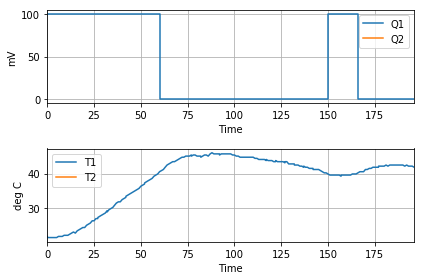

In [7]:
%matplotlib inline
a.plot()

In [5]:
import random
random.randint(10,22)

19

In [8]:
import sys

sys.path.append("../TCLab")
from TCLab import TCLab


In [9]:
a = TCLab()


Opening connection
TCLab connected via Arduino on port /dev/tty.wchusbserial1410


In [11]:
a.T1

22.83

In [12]:
a.T2

22.19

In [13]:
a.Q1 = 150

In [14]:
a.T1

25.09

In [17]:
import time


In [18]:
for k in range(0,10):
    print(a.T1)
    time.sleep(2)

50.55
51.84
53.13
54.41
55.38
56.67
57.96
58.93
60.21
61.5


In [19]:
a.Q1 = 0
